# Linear inverse solutions in NumPy

An exploration of linear seismic inversion — considering the particular problem of getting reflectivity from a seismic trace, given the wavelet.

We'll be working on a model, so we know the correct answer from the start.

**This notebook requires Python 3.5 and Numpy 1.11.**

First, the usual preliminaries.

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from utils import plot_all
%matplotlib inline

In [2]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

Some of the regressors require sklearn 0.18.

In [3]:
import sklearn
sklearn.__version__

'0.18'

In [4]:
def norm(m):
    return m.T @ m

def misfit(d, d_pred):
    misfit = (d_pred - d).T @ (d_pred - d)
    return np.asscalar(misfit)

In [5]:
from scipy import linalg as spla

def convmtx(h, n):
    """
    Equivalent of MATLAB's convmtx function, http://www.mathworks.com/help/signal/ref/convmtx.html.
    
    Makes the convolution matrix, C. The product C.x is the convolution of h and x.
    
    Args
        h (ndarray): a 1D array, the kernel.
        n (int): the number of rows to make.
        
    Returns
        ndarray. Size m+n-1
    """
    col_1 = np.r_[h[0], np.zeros(n-1)]
    row_1 = np.r_[h, np.zeros(n-1)]
    return spla.toeplitz(col_1, row_1)

In [6]:
convmtx([1, -1], 5)

array([[ 1., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -1.]])

## Construct the model m

We start with the slightly odd-seeming number of samples 51. This is because when we calculate the impedance contrasts (reflectivities), we'll lose a sample. Since I'd like 50 samples in the final reflectivity model `m`, we have to start with 50 + 1 samples in the impedance model.

In [7]:
# Impedance, imp     VP    RHO
imp = np.ones(51) * 2550 * 2650
imp[10:15] =        2700 * 2750
imp[15:27] =        2400 * 2450
imp[27:35] =        2800 * 3000

Make a consistent `x` space for the model to live in. This might be 'depth'.

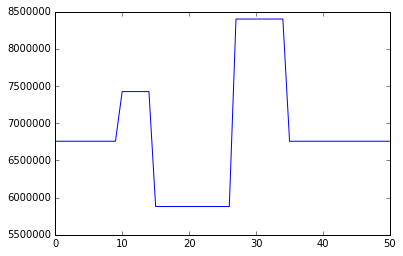

In [8]:
plt.plot(imp)

But I really want to use the reflectivity, so let's compute that:

In [9]:
m = (imp[1:] - imp[:-1]) / (imp[1:] + imp[:-1])

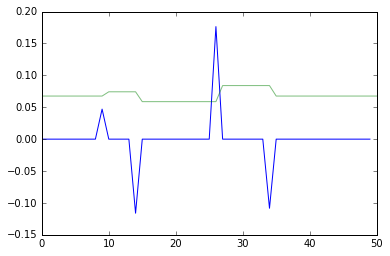

In [10]:
plt.plot(m)

# We can plot the impedance too, scaled to fit on this plot, so we
# can see how the interface property relates to the rock property.
plt.plot(imp/1e8, alpha=0.5)

Notice that we lost a sample: now there are only 50 samples. This is what we wanted.

## Forward operator: convolution with wavelet

Now we make the kernel matrix *G*, which represents convolution.

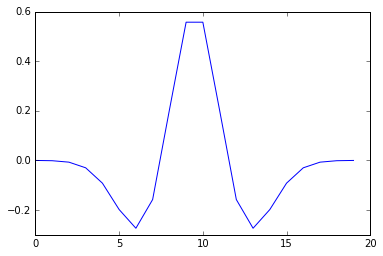

In [11]:
from scipy.signal import ricker
wavelet = ricker(points=20, a=2)

plt.plot(wavelet)

Let's normalize the wavelet amplitude to 1 so that the amplitude relates directly to the reflectivity.

In [12]:
wavelet /= np.amax(wavelet)

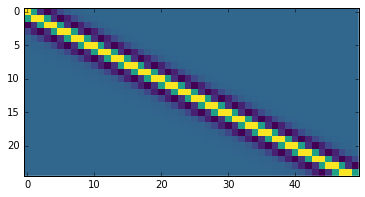

In [13]:
# Downsampling: set to 1 to use every sample.
s = 2

# Make G.
G = convmtx(wavelet, m.size)[::s, 10:60]
plt.imshow(G, cmap='viridis', interpolation='none')

In [14]:
# Or we can use bruges (pip install bruges)
# from bruges.filters import ricker
# wavelet = ricker(duration=0.04, dt=0.001, f=100)
# G = convmtx(wavelet, m.size)[::s, 21:71]

# f, (ax0, ax1) = plt.subplots(1, 2)
# ax0.plot(wavelet)
# ax1.imshow(G, cmap='viridis', interpolation='none', aspect='auto')

## Forward model the data d

Now we can perform the forward problem: computing the data. We use the formulation

$$ \mathbf{d} = \mathbf{Gm} $$

Note that this equation is often rearranged and written $$ \mathbf{Ax} = \mathbf{b} $$ in linear algebra textbooks and in other tutorials, etc. Just in case you're looking for more examples. In that case, **A** is analogous to **G**, and **b** to **d**, and we're solving for **x** not **m**. All just notation &mdash; we can of course call things whatever we want.

In [15]:
d = G @ m

Let's visualize these components for fun...

In [16]:
def add_subplot_axes(ax, rect, axisbg='w'):
    """
    Facilitates the addition of a small subplot within another plot.

    From: http://stackoverflow.com/questions/17458580/
    embedding-small-plots-inside-subplots-in-matplotlib

    License: CC-BY-SA

    Args:
        ax (axis): A matplotlib axis.
        rect (list): A rect specifying [left pos, bot pos, width, height]
    Returns:
        axis: The sub-axis in the specified position.
    """
    def axis_to_fig(axis):
        fig = axis.figure

        def transform(coord):
            a = axis.transAxes.transform(coord)
            return fig.transFigure.inverted().transform(a)

        return transform

    fig = plt.gcf()
    left, bottom, width, height = rect
    trans = axis_to_fig(ax)
    x1, y1 = trans((left, bottom))
    x2, y2 = trans((left + width, bottom + height))
    subax = fig.add_axes([x1, y1, x2 - x1, y2 - y1])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2] ** 0.5
    y_labelsize *= rect[3] ** 0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    
    return subax

/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


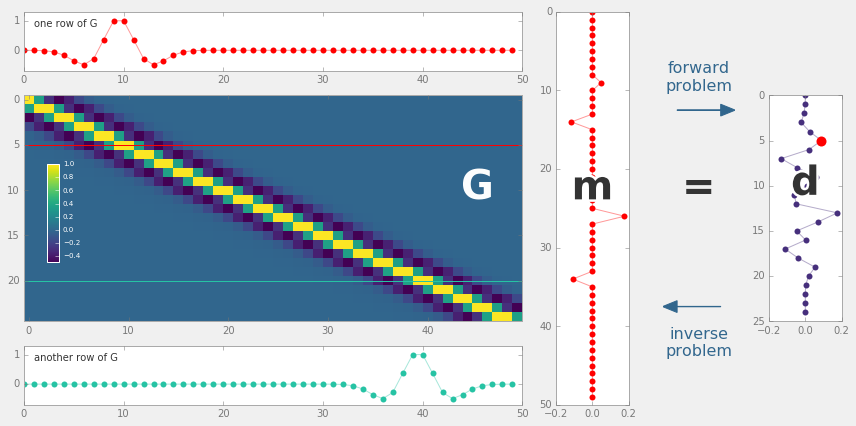

In [17]:
import matplotlib.patheffects as pe
from matplotlib import gridspec, spines

fig = plt.figure(figsize=(12, 6), facecolor='#f0f0f0')

gs = gridspec.GridSpec(5, 8) 

# Set up axes.
axw = plt.subplot(gs[0, :5])   # Wavelet.
axg = plt.subplot(gs[1:4, :5]) # G
axv = plt.subplot(gs[4, :5])   # Other wavelet.
axm = plt.subplot(gs[:, 5])    # m
axe = plt.subplot(gs[:, 6])    # =
axd = plt.subplot(gs[1:4, 7])    # d

cax = add_subplot_axes(axg, [-0.14, 0.22, 0.03, 0.5])

params = {'ha': 'center', 
          'va': 'bottom',
          'size': 40,
          'weight': 'bold',
         }

axw.plot(G[5], 'o', c='r', mew=0)
axw.plot(G[5], 'r', alpha=0.4)
axw.locator_params(axis='y', nbins=3)
axw.text(1, 0.8, "one row of G", color='#333333')
axw.set_ylim(-0.7, 1.3)

cyan = '#26c3a4'

im = axg.imshow(G, cmap='viridis',
                aspect='auto',
                interpolation='none')
axg.text(45, G.shape[0]//2, "G", color='w', **params)
axg.axhline(5, color='r')
axg.axhline(20, color=cyan)
cb = plt.colorbar(im, cax=cax)

axv.plot(G[20], 'o', c=cyan, mew=0)
axv.plot(G[20], cyan, alpha=0.4)
axv.locator_params(axis='y', nbins=3)
axv.text(1, 0.8, "another row of G", color='#333333')
axv.set_ylim(-0.7, 1.3)

y = np.arange(m.size)
axm.plot(m, y, 'o', c='r', mew=0)
axm.plot(m, y, c='r', alpha=0.4)
#axm.imshow(np.expand_dims(m, 1), cmap='viridis', interpolation='none', aspect='auto')
txt = axm.text(0, m.size//2, "m", color='#333333', **params)
txt.set_path_effects([pe.withStroke(linewidth=5, foreground='w')])
axm.invert_yaxis()
axm.set_xlim(-0.2, 0.2)
axm.locator_params(axis='x', nbins=3)

axe.set_frame_on(False)
axe.set_xticks([])
axe.set_yticks([])
axe.text(0.5, 0.5, "=", color='#333333', **params)
axe.text(0.5, 0.8, "forward\nproblem", color='#31668d', size=16, ha='center')
axe.arrow(0.2, 0.75, 0.6, 0, head_width=0.03, head_length=0.2, fc='#31668d', ec='#31668d')
axe.text(0.5, 0.2, "inverse\nproblem", color='#31668d', size=16, ha='center', va='top')
axe.arrow(0.8, 0.25, -0.6, 0, head_width=0.03, head_length=0.2, fc='#31668d', ec='#31668d')

y = np.arange(d.size)
axd.plot(d, y, 'o', c='#462f7c', mew=0)
axd.plot(d, y, c='#462f7c', alpha=0.4)
axd.plot(d[5], y[5], 'o', c='r', mew=0, ms=10)
#axd.imshow(np.expand_dims(d, 1), cmap='viridis', interpolation='none', aspect='auto')
txt = axd.text(0, d.size//2, "d", color='#333333', **params)
txt.set_path_effects([pe.withStroke(linewidth=5, foreground='w')])
axd.invert_yaxis()
axd.set_xlim(-0.2, 0.2)
axd.locator_params(axis='x', nbins=3)

for ax in fig.axes:
    ax.xaxis.label.set_color('#777777')
    ax.tick_params(axis='y', colors='#777777')
    ax.tick_params(axis='x', colors='#777777')
    for child in ax.get_children():
        if isinstance(child, spines.Spine):
            child.set_color('#aaaaaa')

cb.outline.set_edgecolor('white')
cax.xaxis.label.set_color('#ffffff')
cax.tick_params(axis='y', colors='#ffffff')
cax.tick_params(axis='x', colors='#ffffff')

fig.tight_layout()
plt.savefig("figures/figure1.png", dpi=200, facecolor=fig.get_facecolor())
plt.show()

Note that `G * m` gives us exactly the same result as `np.convolve(w_, m)`. This is just another way of implementing convolution that lets us use linear algebra to perform the operation, and its inverse.

In [18]:
plt.plot(np.convolve(w, m, mode='same')[::s], c='#462f7c', lw=3)
plt.plot(G @ m, 'red')

NameError: name 'w' is not defined

Now we can move on to the more interesting problem: if we only know a few measurements (i.e. this data `d`) and the kernel `G` that represents our understanding of the geophysics, can we _guess_ the model? 

<hr />

## Noise-free: minimum norm

In [ ]:
# If G is square and invertible, we can use the inverse directly:
# m_est = la.inv(G) @ d

# If G is fat (more columns than rows: underdetermined system),
# then we use the 'right' pseduo-inverse of G:
m_est = G.T @ la.inv(G @ G.T) @ d

# If G is skinny (more rows than columns: overdetermined),
# we use the left inverse:
# m_est = la.inv(G.T @ G) @ G.T @ d

d_pred = G @ m_est

In [ ]:
def plot_two(m, d, m_est, d_pred, equalize=True):
    """
    Helper function for plotting. You can ignore this.
    """
    fig = plt.figure(figsize=(16,4), facecolor='#f0f0f0')

    alpha = 0.5
    
    ax0 = fig.add_subplot(1,2,1)
    ax0.plot(m, c="#31668d", alpha=alpha)
    ax0.plot(m, 'o', c="#31668d", ms=4, alpha=alpha)
    ax0.plot(m_est, c="#462f7c", lw=1.4)
    ax0.plot(m_est, 'o', c="#462f7c", ms=4)
    ax0.set_title("Model and estimated model", size=16)
    ax0.text(35, -0.1, "m", color="#31668d", alpha=alpha+0.05, size=22)
    ax0.text(35, -0.12, "$\mathrm{{norm}} = {:.3f}$".format(norm(m)), color="#31668d", alpha=alpha+0.15, size=16)
    ax0.text(28, 0.08, "m_est", color="#462f7c", size=22)
    ax0.text(28, 0.05, "$\mathrm{{norm}} = {:.3f}$".format(norm(m_est)), color="#462f7c", size=16)

    ax1 = fig.add_subplot(1,2,2)
    ax1.plot(d, 'o', c="#31668d", mew=0, ms=5, alpha=alpha)
    ax1.plot(d, c="#31668d", alpha=alpha)
    ax1.plot(d_pred, 'o', c="#462f7c", ms=5, mew=0)
    ax1.plot(d_pred, c="#462f7c", lw=1.4)
    ax1.set_title("Data and predicted data", size=16)
    ax1.text(11.3, 0.13, "d", color="#31668d", alpha=alpha+0.05, size=22)
    ax1.text(14, 0.13, "d_pred", color="#462f7c", size=22)
    ax1.text(14, 0.096, "$\mathrm{{misfit}} = {:.3f}$".format(misfit(d, d_pred)), color="#462f7c", size=16)

    for ax in fig.axes:
        ax.xaxis.label.set_color('#777777')
        ax.tick_params(axis='y', colors='#777777')
        ax.tick_params(axis='x', colors='#777777')
        for child in ax.get_children():
            if isinstance(child, spines.Spine):
                child.set_color('#aaaaaa')


    plt.savefig('figures/figure2.png', dpi=200, facecolor=fig.get_facecolor())
    plt.show()

In [ ]:
plot_two(m, d, m_est, d_pred)

It's interesting to look at these intermediate arrays:

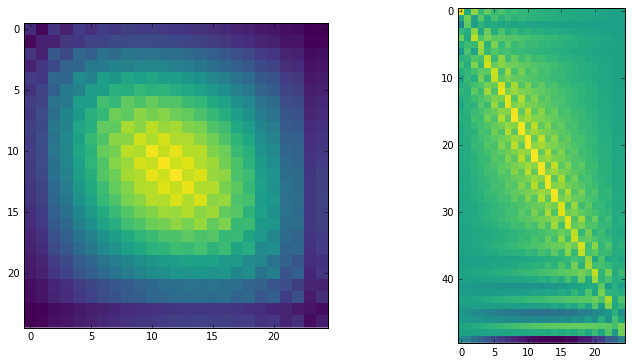

In [19]:
fig = plt.figure(figsize=(12,6))
ax0 = fig.add_subplot(121)
_ = ax0.imshow(la.inv(G @ G.T), cmap='viridis', interpolation='none')
ax1 = fig.add_subplot(122)
_ = ax1.imshow(G.T @ la.inv(G @ G.T), cmap='viridis', interpolation='none')

<hr />

## Aside: minimum norm without inverting G

["Don't invert that matrix!"](http://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix/) — says John Cook, and we should listen to John because he is much smarter than us.

OK, no problem... We can use other solvers, like `np.linalg.solve`, or `scipy.linalg.lu_solve`. These are implemented via LAPACK `gesv` and are much faster than inverting matrices with NumPy. 

### linalg.solve or linalg.lstsq

Best solution by least squares.


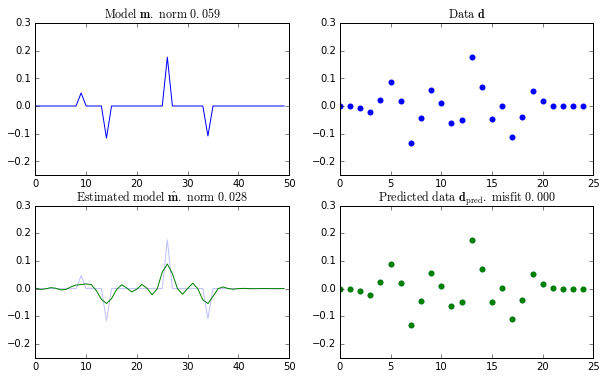

In [20]:
try:
    """Exact solution, matrix must be square and full-rank."""
    m_est = la.solve(G, d)
    print("Exact solution.")
except la.LinAlgError:
    """The problem is underdetermined, find optimal solution."""
    m_est = la.lstsq(G, d)[0]
    print("Best solution by least squares.")

d_pred = G @ m_est
plot_all(m, d, m_est, d_pred)

### QR factorization

Only works if **G** is square.

In [21]:
q, r = la.qr(G)

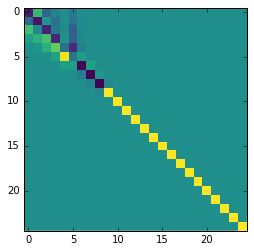

In [22]:
plt.imshow(q, cmap='viridis', interpolation='none')

In [23]:
m_est = la.inv(r) @ q.T @ d
d_pred = G @ m_est
plot_all(m, d, m_est, d_pred, equalize=False)

LinAlgError: Last 2 dimensions of the array must be square

### LU factorization

Again, **G** must be square.

/home/matt/anaconda/envs/linalg/lib/python3.5/site-packages/scipy/linalg/decomp_lu.py:71: RuntimeWarning: Diagonal number 12 is exactly zero. Singular matrix.
  RuntimeWarning)


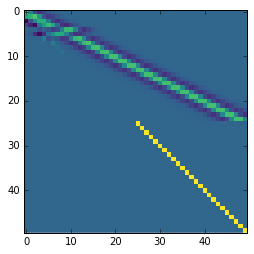

In [54]:
lu, piv = spla.lu_factor(G)
plt.imshow(lu, cmap='viridis', interpolation='none')

In [56]:
m_est = spla.lu_solve((lu, piv), d)
d_pred = G @ m_est
plot_all(m, d, m_est, d_pred, equalize=False)

ValueError: incompatible dimensions.

<hr />

## With noise: minimum weighted norm, or damped least squares

Now let's add noise! It's going to make things harder.

First, add noise:

In [24]:
s = 0.025
d = G @ m + s * (np.random.random(d.shape) - 0.5)

Now the minimum norm doesn't work so well:

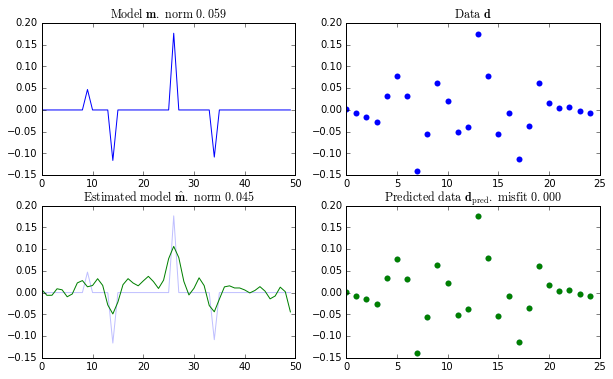

In [25]:
m_est = G.T @ la.inv(G @ G.T) @ d
d_pred = G @ m_est

plot_all(m, d, m_est, d_pred, equalize=False)

Now use Mauricio's second form:

In [26]:
I = np.eye(G.shape[0])
µ = 2.5  # We can use Unicode symbols in Python 3, just be careful
m_est = G.T @ la.inv(G @ G.T + µ * I) @ d
d_pred = G @ m_est

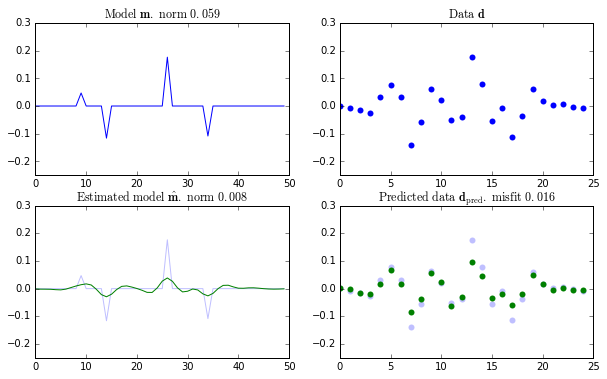

In [27]:
plot_all(m, d, m_est, d_pred)

## Minimum weighted norm with first derivative regularization

In [28]:
W = convmtx([1, -1], m.size)[:, :-1]  # Skip last column

Now we solve:

$$ \hat{\mathbf{m}} = (\mathbf{G}^\mathrm{T} \mathbf{G} + \mu \mathbf{W}^\mathrm{T} \mathbf{W})^{-1} \mathbf{G}^\mathrm{T} \mathbf{d} \ \ $$

In [29]:
m_est = la.inv(G.T @ G + µ * W.T @ W) @ G.T @ d
d_pred = G @ m_est

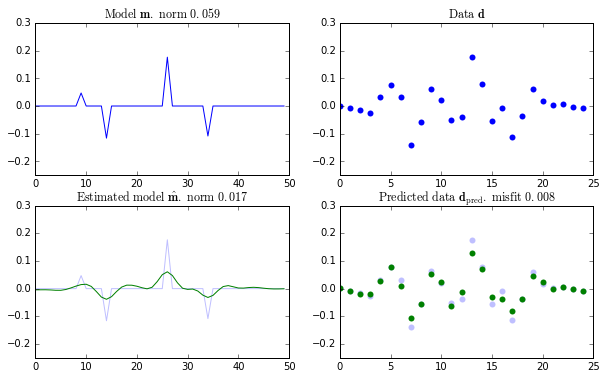

In [30]:
plot_all(m, d, m_est, d_pred)

## Minimum weighted norm with second derivative regularization

In [31]:
W = convmtx([1, -2, 1], m.size)[:, 1:-1]  # Skip first and last columns.

In [32]:
Q = la.inv(W @ W.T)

In [33]:
m_est = Q @ G.T @ la.inv(G @ Q @ G.T) @ d
d_pred = G @ m_est

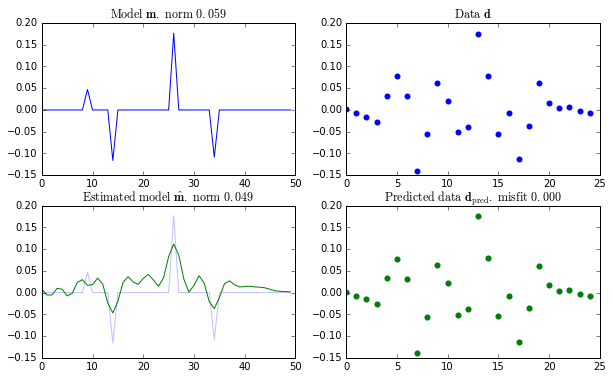

In [34]:
plot_all(m, d, m_est, d_pred, equalize=False)

## Scikit Learn

Scikit-Learn is a machine learning package that has a large number of linear models, to do different kinds of regression with regularization. These will perform much better in the face of noise.

In [35]:
from sklearn import linear_model

### Ridge regression

Linear Model trained with L2 regularization.

[sklearn.linear_model.Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)

Also known as [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization). 

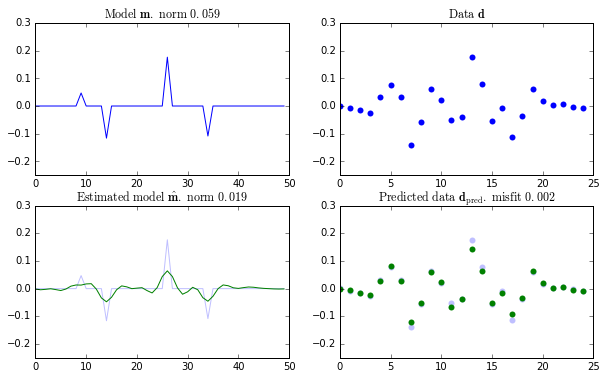

In [36]:
reg = linear_model.Ridge(alpha=0.5, fit_intercept=False)
reg.fit(G, d)
m_est = reg.coef_
d_pred = G @ m_est
plot_all(m, d, m_est, d_pred)

### Lasso

[The docs](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)

Linear Model trained with L1 prior as regularizer (aka the Lasso).

For reasons I don't understand, I cannot get the ordinary `Lasso` mode to fit.

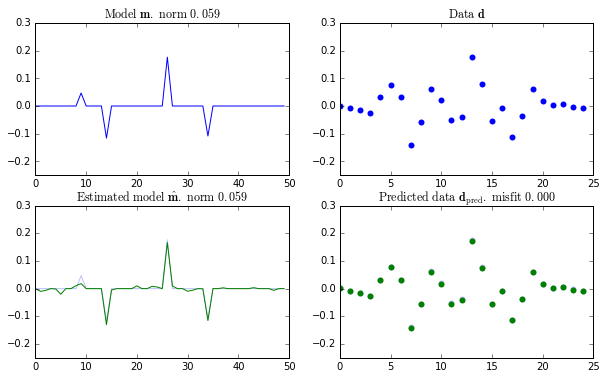

In [37]:
reg = linear_model.LassoCV(fit_intercept=False)
reg.fit(G, d)
m_est = reg.coef_
d_pred = G @ m_est
plot_all(m, d, m_est, d_pred)

### Orthogonal matching pursuit

[The docs](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.OrthogonalMatchingPursuit.html#sklearn.linear_model.OrthogonalMatchingPursuit)

Seems like a sort of sparse spike inversion.

Can provide number of spikes, or tolerance. Try setting `n_nonzero_coefs` or `tol` hyperparameters.

/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/linear_model/omp.py:391: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)


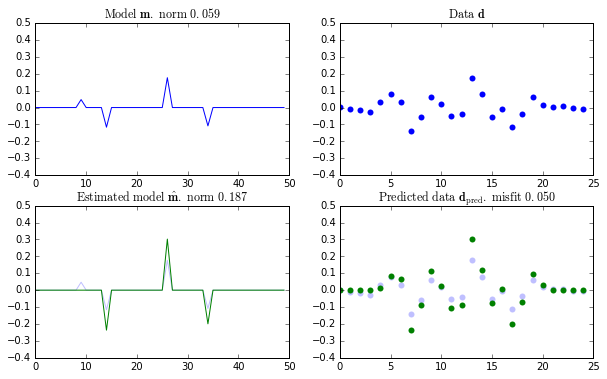

In [38]:
reg = linear_model.OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=5)
reg.fit(G, d)
m_est = reg.coef_
d_pred = G @ m_est
plot_all(m, d, m_est, d_pred)